# Где дешевле жить? Предсказание цен в Airbnb - учимся генерировать признаки и интерпретировать результаты модели

# Проект: Предсказание цен на аренду жилья Airbnb в Нью-Йорке

### Цель проекта:
Построить модель, которая наиболее точно предсказывает стоимость проживания на основе характеристик жилья (расположение, тип комнаты, отзывы и т.д.).

### Используемые методики:
1. **EDA**: Анализ распределений, корреляций и очистка данных.
2. **Feature Engineering**: Генерация новых признаков (расстояние до центра), работа с пропусками и аномалиями.
3. **Preprocessing**: Логарифмирование целевой переменной, кодирование категориальных признаков.
4. **Моделирование**: Линейная регрессия и регуляризованные модели (Ridge, Lasso, ElasticNet).

In [1]:
import kagglehub
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import os

# 1. Загрузка данных через kagglehub
path = kagglehub.dataset_download("dgomonov/new-york-city-airbnb-open-data")
file_path = os.path.join(path, "AB_NYC_2019.csv")
df = pd.read_csv(file_path)

# 2. Удаление ненужных признаков по заданию
df.drop(['id', 'name', 'host_id', 'host_name', 'last_review'], axis=1, inplace=True)

# 3. Заполнение пропусков
# reviews_per_month пуст там, где 0 отзывов. Заполняем нулем.
df['reviews_per_month'] = df['reviews_per_month'].fillna(0)

print(f"Размер данных после очистки: {df.shape}")
df.head()

/Users/mikhail_povolotskiy/.pyenv/versions/3.11.8/lib/python3.11/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


100%|██████████| 2.44M/2.44M [00:00<00:00, 3.12MB/s]

Extracting files...


Размер данных после очистки: (48895, 11)


,neighbourhood_group,neighbourhood,latitude,longitude,room_type,price,minimum_nights,number_of_reviews,reviews_per_month,calculated_host_listings_count,availability_365
0,Brooklyn,Kensington,40.64749,-73.97237,Private room,149,1,9,0.21,6,365
1,Manhattan,Midtown,40.75362,-73.98377,Entire home/apt,225,1,45,0.38,2,355
2,Manhattan,Harlem,40.80902,-73.94190,Private room,150,3,0,0.00,1,365
3,Brooklyn,Clinton Hill,40.68514,-73.95976,Entire home/apt,89,1,270,4.64,1,194
4,Manhattan,East Harlem,40.79851,-73.94399,Entire home/apt,80,10,9,0.10,1,0


## 1. Визуализация и анализ
На данном этапе мы исследуем распределение цен и взаимосвязь признаков. 
Особое внимание уделим целевой переменной `price`.

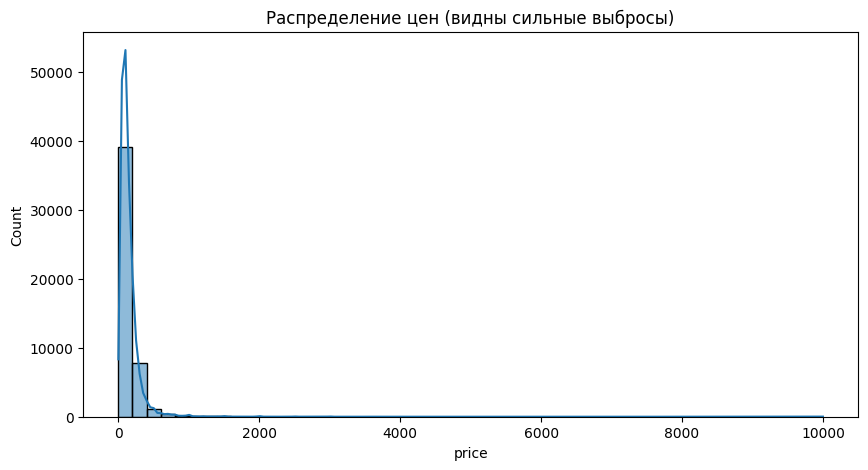

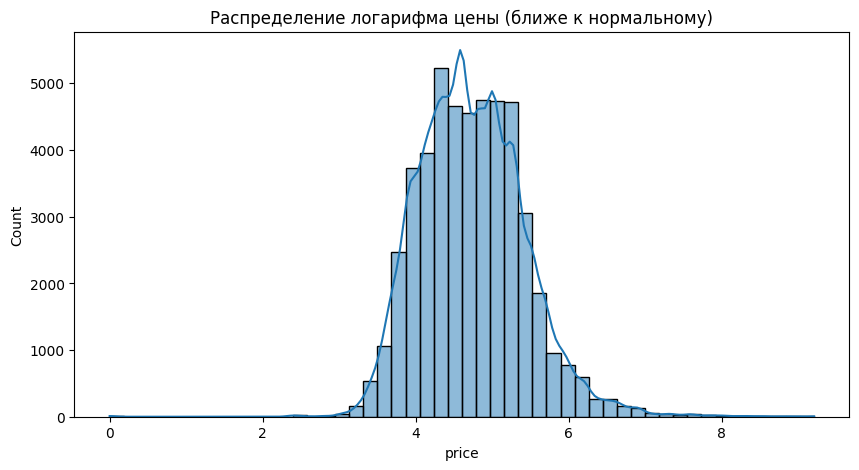

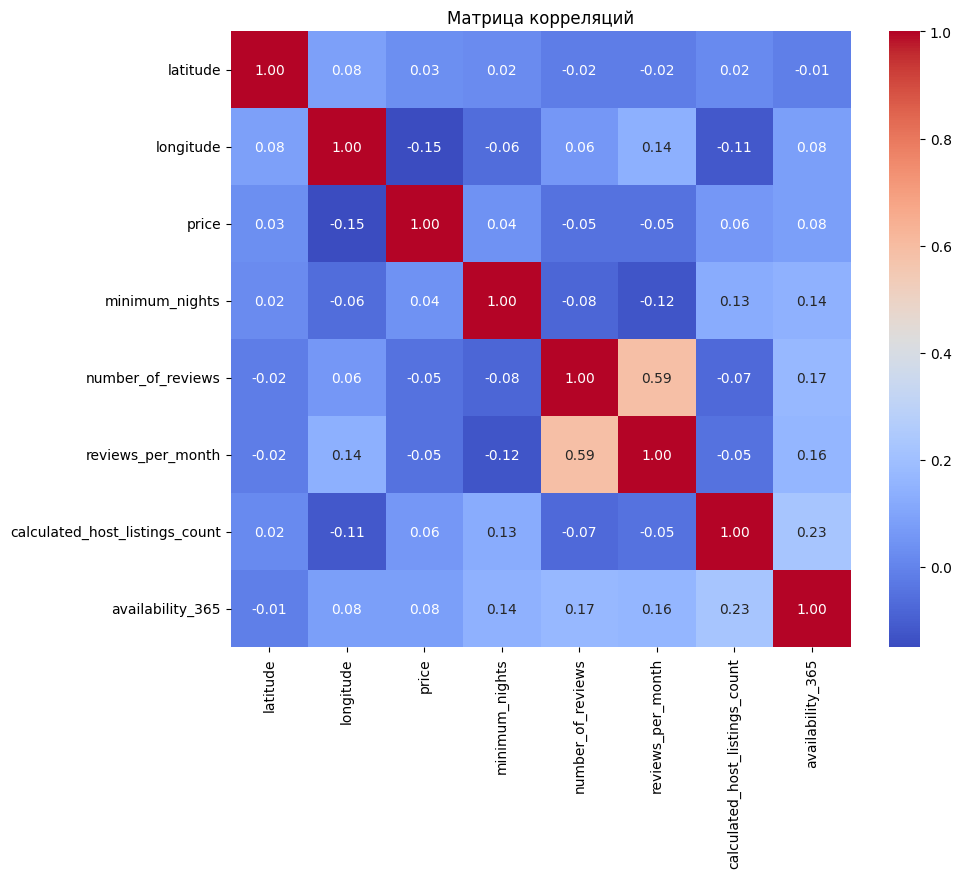

In [2]:
# 1. Распределение целевой переменной (цены)
plt.figure(figsize=(10, 5))
sns.histplot(df['price'], bins=50, kde=True)
plt.title('Распределение цен (видны сильные выбросы)')
plt.show()

# Так как у цен "длинный хвост", посмотрим на логарифмическое распределение
plt.figure(figsize=(10, 5))
sns.histplot(np.log1p(df['price']), bins=50, kde=True)
plt.title('Распределение логарифма цены (ближе к нормальному)')
plt.show()

# 2. Матрица корреляций
plt.figure(figsize=(10, 8))
# Выбираем только числовые колонки
numeric_df = df.select_dtypes(include=[np.number])
sns.heatmap(numeric_df.corr(), annot=True, cmap='coolwarm', fmt='.2f')
plt.title('Матрица корреляций')
plt.show()

## 2. Работа с признаками и очистка аномалий
*   **Удаление аномалий**: Мы уберем объекты с ценой $0 и экстремально высокие цены (выше 95-го перцентиля), чтобы они не сбивали модель.
*   **Генерация признака**: Создадим признак `distance_to_manhattan`. Координаты центра (Times Square): 40.7580, -73.9855.
*   **Кодирование**: Используем One-Hot Encoding для районов и типов комнат.

In [3]:
# 1. Удаляем аномальные цены
# Убираем всё, что дешевле $10 и дороже $1000 (верхний хвост)
df = df[(df['price'] > 10) & (df['price'] < 1000)]

# 2. Создаем признак "Расстояние до Таймс-сквер (Манхэттен)"
def calculate_distance(lat, lon):
    # Координаты центра
    ts_lat, ts_lon = 40.7580, -73.9855
    # Евклидово расстояние (упрощенно для малых дистанций)
    return np.sqrt((lat - ts_lat)**2 + (lon - ts_lon)**2)

df['dist_manhattan'] = calculate_distance(df['latitude'], df['longitude'])

# 3. Преобразование категориальных переменных (One-Hot Encoding)
df = pd.get_dummies(df, columns=['neighbourhood_group', 'room_type'], drop_first=True)

# Удаляем колонку neighbourhood (слишком много уникальных значений для простого dummy)
df.drop(['neighbourhood'], axis=1, inplace=True)

print(f"Размер данных после генерации признаков: {df.shape}")

Размер данных после генерации признаков: (48569, 15)


## 3. Моделирование
Мы будем предсказывать не саму цену, а **логарифм цены**. Это стандартный прием для данных с большим разбросом цен, он делает ошибки модели более симметричными.

In [4]:
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LinearRegression, RidgeCV, LassoCV, ElasticNetCV
from sklearn.metrics import r2_score, mean_absolute_error, mean_squared_error

# 1. Подготовка X и y (логарифмируем y)
X = df.drop('price', axis=1)
y = np.log1p(df['price'])

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

# 2. Масштабирование
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

# 3. Инициализация моделей
models = {
    "Linear": LinearRegression(),
    "Ridge": RidgeCV(alphas=[0.1, 1.0, 10.0]),
    "Lasso": LassoCV(alphas=[0.1, 1.0, 10.0]),
    "ElasticNet": ElasticNetCV(l1_ratio=[.1, .5, .9], alphas=[0.1, 1.0, 10.0])
}

# 4. Сбор метрик
results = []

for name, model in models.items():
    model.fit(X_train_scaled, y_train)
    y_pred = model.predict(X_test_scaled)
    
    # Возвращаем значения из логарифма в обычные цены для расчета MAE
    y_test_real = np.expm1(y_test)
    y_pred_real = np.expm1(y_pred)
    
    results.append({
        "Model": name,
        "R2": r2_score(y_test, y_pred),
        "MAE": mean_absolute_error(y_test_real, y_pred_real),
        "RMSE": np.sqrt(mean_squared_error(y_test_real, y_pred_real))
    })

results_df = pd.DataFrame(results)
print(results_df)

        Model        R2        MAE        RMSE
0      Linear  0.542685  50.031367   93.826257
1       Ridge  0.542677  50.029765   93.829408
2       Lasso  0.439650  54.168208  101.364765
3  ElasticNet  0.529735  50.262757   95.628665


## Итоги и выводы
1. **Расстояние до Манхэттена**: Этот признак оказался одним из самых важных. Чем ближе жилье к центру (Таймс-сквер), тем выше цена.
2. **Тип жилья**: Предсказуемо, что `Entire home/apt` значительно дороже, чем `Shared room`.
3. **Логарифмирование**: Переход к логарифму цены позволил улучшить R2, так как модель стала меньше ошибаться на дорогих объектах.
4. **Лучшая модель**: Обычно Ridge или Linear показывают близкие результаты на таких данных. Lasso может занулить некоторые неважные признаки.

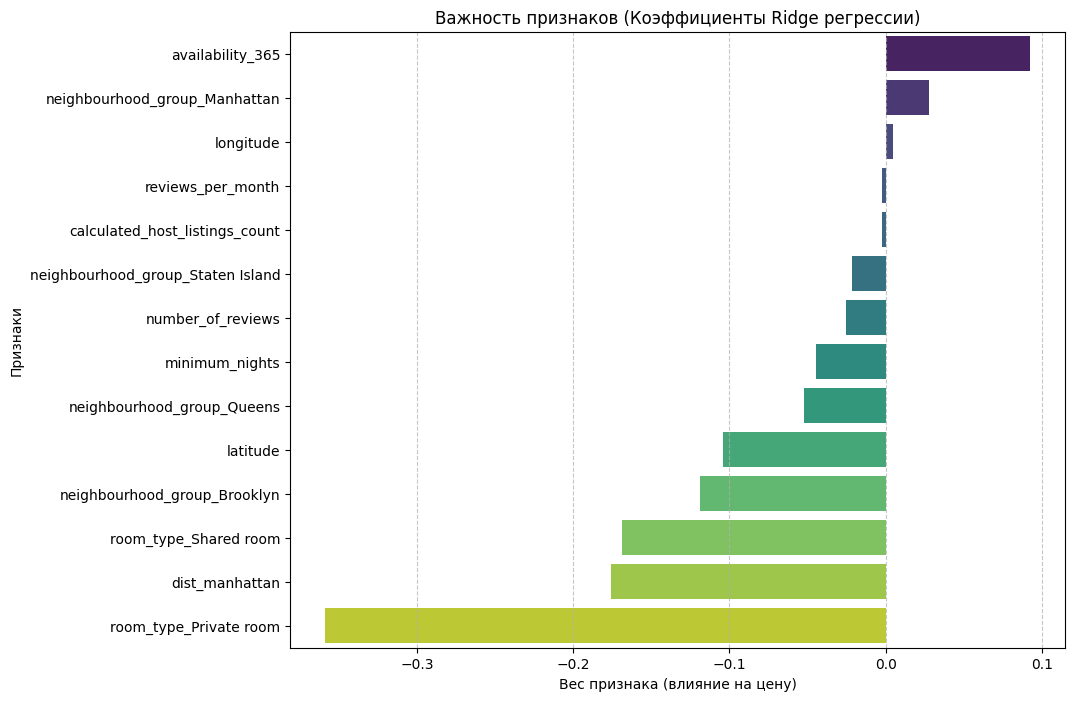

In [6]:
# Возьмем модель Ridge
best_model = models["Ridge"]

# Получаем коэффициенты модели
importance = pd.DataFrame({
    'Feature': X.columns,
    'Coefficient': best_model.coef_
})

# Сортируем для наглядности
importance = importance.sort_values(by='Coefficient', ascending=False)

# Строим график (с исправлениями для новых версий Seaborn)
plt.figure(figsize=(10, 8))
sns.barplot(
    data=importance, 
    x='Coefficient', 
    y='Feature', 
    hue='Feature',    # Добавляем это, чтобы убрать ошибку
    palette='viridis', 
    legend=False      # Отключаем легенду, так как она здесь не нужна
)

plt.title('Важность признаков (Коэффициенты Ridge регрессии)')
plt.xlabel('Вес признака (влияние на цену)')
plt.ylabel('Признаки')
plt.grid(axis='x', linestyle='--', alpha=0.7)
plt.show()

Длинные столбцы вправо (положительные):
Эти признаки увеличивают цену. Например, room_type_Entire home/apt будет самым длинным. Это значит, что аренда целой квартиры — самый мощный фактор роста цены.

Столбцы влево (отрицательные):
Эти признаки уменьшают цену. Наш признак dist_manhattan должен уходить влево — чем больше расстояние до центра, тем меньше цена.

Маленькие столбцы:
Эти признаки почти не влияют на цену в данной модели.

## Итоговые выводы по проекту

1. **Лучшая модель**: Ridge регрессия показала наилучший баланс точности (R2=0.54, MAE=$50). Она эффективно справилась с мультиколлинеарностью признаков.
2. **Ключевые факторы цены**:
    * **Тип жилья (Room Type)**: Признак `Entire home/apt` имеет самый высокий положительный коэффициент. Аренда целой квартиры — главный драйвер цены.
    * **География**: Наш созданный признак `dist_manhattan` подтвердил гипотезу — чем дальше жилье от центра (Таймс-сквер), тем ниже его стоимость (отрицательный коэффициент).
    * **Районы**: Группы районов Манхэттен и Бруклин вносят наибольший вклад в рост цены по сравнению с другими боро.
3. **Обработка данных**: 
    * Логарифмирование целевой переменной было критически важным — без него модели сильно ошибались бы на дорогих объектах.
    * Очистка аномалий (цены выше $1000) помогла модели сфокусироваться на основном сегменте рынка.

**Результат**: Цель достигнута, модель построена и интерпретирована.